## Data preparation using data block

In [1]:
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 4.0MB 45.1MB/s 
  Found existing installation: torch 1.5.0+cu101
    Uninstalling torch-1.5.0+cu101:
      Successfully uninstalled torch-1.5.0+cu101
  Found existing installation: torchvision 0.6.0+cu101
    Uninstalling torchvision-0.6.0+cu101:
      Successfully uninstalled torchvision-0.6.0+cu101


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.vision import *
root_dir = "/content/drive/My Drive/"
base_dir = root_dir + 'Resnet_vs_Densenet/'
path_ = Path('/content/drive/My Drive/Resnet_vs_Densenet/data/nigerianCurrencies')

In [3]:
path_ 
path_.ls()

[PosixPath('/content/drive/My Drive/Resnet_vs_Densenet/data/nigerianCurrencies/train'),
 PosixPath('/content/drive/My Drive/Resnet_vs_Densenet/data/nigerianCurrencies/valid'),
 PosixPath('/content/drive/My Drive/Resnet_vs_Densenet/data/nigerianCurrencies/.ipynb_checkpoints'),
 PosixPath('/content/drive/My Drive/Resnet_vs_Densenet/data/nigerianCurrencies/test'),
 PosixPath('/content/drive/My Drive/Resnet_vs_Densenet/data/nigerianCurrencies/models')]

N10 torch.Size([3, 329, 600])


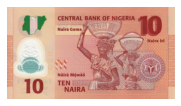

In [4]:
il = ImageList.from_folder(path_)


# let's split the contents of the item list into training and validaton sets using the two folders in path
#remember that you could use no_split to create an emty validation set

sd = il.split_by_folder(train='train', valid = 'valid')


# inside both training and validation sets, there's a folder with a label for each class
# we will create a list of labels from those folders
# check out label_from_folder() source code on fast ai

ll = sd.label_from_folder()


# You can index into the label list 'll' to get both the independent variable (x) which is the image
# and the dependent variable (y) which is the class that the image belongs

x,y = ll.train[0]
# display
x.show()
print(y, x.shape)

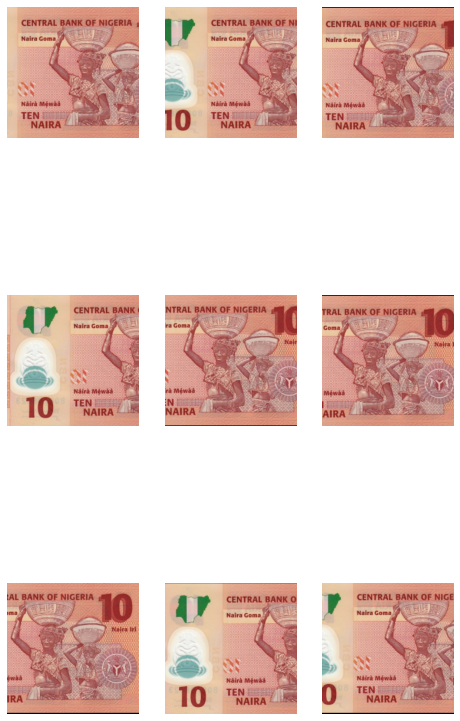

In [5]:
tfms1 = ([*rand_pad(padding=3,size= 224, mode='zeros')], [])

bs = 64

# not using imagenet_stats because not using pretrained model
#data = ll.databunch(bs=bs).normalize()
data = (ll.transform(tfms1, size=224)
        .databunch().normalize())

def _plot(i,j,ax): data.train_ds[0][0].show(ax)
plot_multi(_plot, 3, 3, figsize=(8,15))

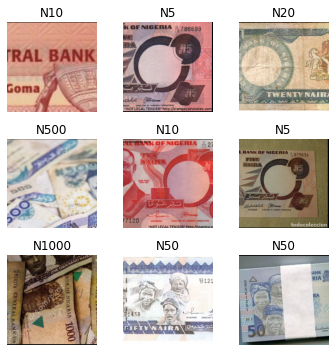

In [6]:
xb,yb = data.one_batch()
xb.shape,yb.shape
data.show_batch(rows=3, figsize=(5,5))

## Building the ResNets

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#import torchvision
import torchvision.transforms as transforms

from functools import partial
from dataclasses import dataclass
from collections import OrderedDict

torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)

In [0]:
class Conv2dAuto(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.padding =  (self.kernel_size[0] // 2, self.kernel_size[1] // 2) # dynamic add padding based on the kernel_size
        
conv3x3 = partial(Conv2dAuto, kernel_size=3, bias=False) 

In [0]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels, self.out_channels =  in_channels, out_channels
        self.blocks = nn.Identity()
        self.shortcut = nn.Identity()   
    
    def forward(self, x):
        residual = x
        if self.should_apply_shortcut: residual = self.shortcut(x)
        x = self.blocks(x)
        x += residual
        return x
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.out_channels

In [0]:
from collections import OrderedDict

class ResNetResidualBlock(ResidualBlock):
    def __init__(self, in_channels, out_channels, expansion=1, downsampling=1, conv=conv3x3, *args, **kwargs):
        super().__init__(in_channels, out_channels)
        self.expansion, self.downsampling, self.conv = expansion, downsampling, conv
        self.shortcut = nn.Sequential(OrderedDict(
        {
            'conv' : nn.Conv2d(self.in_channels, self.expanded_channels, kernel_size=1,
                      stride=self.downsampling, bias=False),
            'bn' : nn.BatchNorm2d(self.expanded_channels)
            
        })) if self.should_apply_shortcut else None
        
        
    @property
    def expanded_channels(self):
        return self.out_channels * self.expansion
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.expanded_channels

In [0]:
from collections import OrderedDict
def conv_bn(in_channels, out_channels, conv, *args, **kwargs):
    return nn.Sequential(OrderedDict({'conv': conv(in_channels, out_channels, *args, **kwargs), 
                          'bn': nn.BatchNorm2d(out_channels) }))
    

class ResNetBasicBlock(ResNetResidualBlock):
    expansion = 1
    def __init__(self, in_channels, out_channels, activation=nn.ReLU, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.blocks = nn.Sequential(
            conv_bn(self.in_channels, self.out_channels, conv=self.conv, bias=False, stride=self.downsampling),
            activation(),
            conv_bn(self.out_channels, self.expanded_channels, conv=self.conv, bias=False),
        )

In [0]:
class ResNetBottleNeckBlock(ResNetResidualBlock):
    expansion = 4
    def __init__(self, in_channels, out_channels, activation=nn.ReLU, *args, **kwargs):
        super().__init__(in_channels, out_channels, expansion=4, *args, **kwargs)
        self.blocks = nn.Sequential(
           conv_bn(self.in_channels, self.out_channels, self.conv, kernel_size=1),
             activation(),
             conv_bn(self.out_channels, self.out_channels, self.conv, kernel_size=3, stride=self.downsampling),
             activation(),
             conv_bn(self.out_channels, self.expanded_channels, self.conv, kernel_size=1),
        )

In [0]:
class ResNetLayer(nn.Module):
    def __init__(self, in_channels, out_channels, block=ResNetBasicBlock, n=1, *args, **kwargs):
        super().__init__()
        # 'We perform downsampling directly by convolutional layers that have a stride of 2.'
        downsampling = 2 if in_channels != out_channels else 1
        
        self.blocks = nn.Sequential(
            block(in_channels , out_channels, *args, **kwargs, downsampling=downsampling),
            *[block(out_channels * block.expansion, 
                    out_channels, downsampling=1, *args, **kwargs) for _ in range(n - 1)]
        )

    def forward(self, x):
        x = self.blocks(x)
        return x

In [0]:
class ResNetEncoder(nn.Module):
    """
    ResNet encoder composed by increasing different layers with increasing features.
    """
    def __init__(self, in_channels=3, blocks_sizes=[64, 128, 256, 512], deepths=[2,2,2,2], 
                 activation=nn.ReLU, block=ResNetBasicBlock, *args,**kwargs):
        super().__init__()
        
        self.blocks_sizes = blocks_sizes
        
        self.gate = nn.Sequential(
            nn.Conv2d(in_channels, self.blocks_sizes[0], kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(self.blocks_sizes[0]),
            activation(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.in_out_block_sizes = list(zip(blocks_sizes, blocks_sizes[1:]))
        self.blocks = nn.ModuleList([ 
            ResNetLayer(blocks_sizes[0], blocks_sizes[0], n=deepths[0], activation=activation, 
                        block=block,  *args, **kwargs),
            *[ResNetLayer(in_channels * block.expansion, 
                          out_channels, n=n, activation=activation, 
                          block=block, *args, **kwargs) 
              for (in_channels, out_channels), n in zip(self.in_out_block_sizes, deepths[1:])]       
        ])
        
        
    def forward(self, x):
        x = self.gate(x)
        for block in self.blocks:
            x = block(x)
        return x

In [0]:
class ResnetDecoder(nn.Module):
    """
    This class represents the tail of ResNet. It performs a global pooling and maps the output to the
    correct class by using a fully connected layer.
    """
    def __init__(self, in_features, n_classes):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d((1, 1))
        self.decoder = nn.Linear(in_features, n_classes)

    def forward(self, x):
        x = self.avg(x)
        x = x.view(x.size(0), -1)
        x = self.decoder(x)
        return x

In [0]:
class ResNet(nn.Module):
    
    def __init__(self, in_channels, n_classes, *args, **kwargs):
        super().__init__()
        self.encoder = ResNetEncoder(in_channels, *args, **kwargs)
        self.decoder = ResnetDecoder(self.encoder.blocks[-1].blocks[-1].expanded_channels, n_classes)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [0]:
def resnet18(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBasicBlock, deepths=[2, 2, 2, 2])

def resnet34(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBasicBlock, deepths=[3, 4, 6, 3])

def resnet50(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 4, 6, 3])

def resnet101(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 4, 23, 3])

def resnet152(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 8, 36, 3])

In [0]:
# from torchsummary import summary

# model = resnet101(3, 1000)
# summary(model.cuda(), (3, 224, 224))

## Train resnet34 with currency dataset

In [0]:
model = resnet34(3, 8)
summary(model.cuda(), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
        Conv2dAuto-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
        Conv2dAuto-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
 ResNetBasicBlock-10           [-1, 64, 56, 56]               0
       Conv2dAuto-11           [-1, 64, 56, 56]          36,864
      BatchNorm2d-12           [-1, 64, 56, 56]             128
             ReLU-13           [-1, 64, 56, 56]               0
       Conv2dAuto-14           [-1, 64,

In [0]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


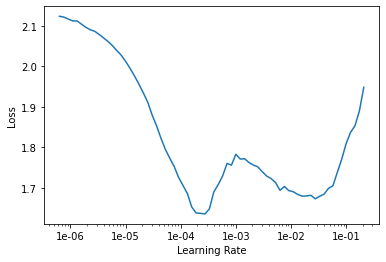

In [0]:
learn.lr_find()
learn.recorder.plot()

Min numerical gradient: 4.37E-05
Min loss divided by 10: 2.75E-05


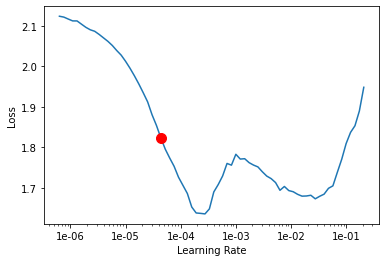

In [0]:
learn.recorder.plot(suggestion = True)

In [0]:
learn.fit_one_cycle(10, 4e-05)

epoch,train_loss,valid_loss,accuracy,time
0,2.095383,2.090929,0.075000,01:07
1,1.971165,2.083303,0.133333,00:09
2,1.784129,2.027698,0.300000,00:09
3,1.609089,1.940520,0.341667,00:09
4,1.447147,1.849519,0.341667,00:10
5,1.300380,1.699679,0.416667,00:09
6,1.171883,1.461771,0.425000,00:09
7,1.061261,1.191074,0.558333,00:10
8,0.966794,0.879633,0.675000,00:09
9,0.887987,0.696432,0.808333,00:09


## Train ResNet101 using currency dataset

In [0]:
model2 = resnet101(3, 8)

In [0]:
learn2 = Learner(data, model2, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-05
Min loss divided by 10: 3.98E-05


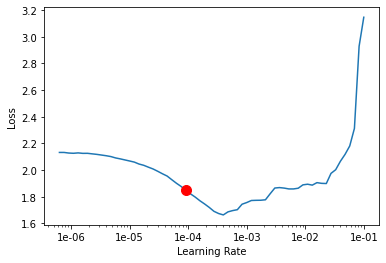

In [0]:
learn2.lr_find()
learn2.recorder.plot(suggestion = True)

In [0]:
learn2.fit_one_cycle(10, 9e-05)

epoch,train_loss,valid_loss,accuracy,time
0,2.107165,2.084215,0.125000,00:15
1,1.974280,2.083364,0.125000,00:15
2,1.778974,2.081184,0.125000,00:14
3,1.594980,2.075838,0.125000,00:14
4,1.451610,2.162604,0.150000,00:15
5,1.302591,2.284028,0.258333,00:14
6,1.176913,2.548671,0.216667,00:15
7,1.078026,2.792314,0.283333,00:14
8,0.973928,2.624576,0.325000,00:15
9,0.893205,2.042726,0.416667,00:14


## Train with ResNet50

In [0]:
model3 = resnet50(3, 8)

In [0]:
learn3 = Learner(data, model3, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.25E-05
Min loss divided by 10: 4.79E-05


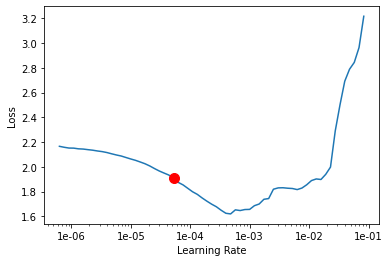

In [0]:
learn3.lr_find()
learn3.recorder.plot(suggestion = True)

In [0]:
learn3.fit_one_cycle(10, 5e-05)

epoch,train_loss,valid_loss,accuracy,time
0,2.141697,2.084153,0.125000,00:11
1,2.010536,2.083791,0.125000,00:11
2,1.846515,2.076375,0.125000,00:12
3,1.690706,2.095296,0.158333,00:12
4,1.540556,2.113808,0.125000,00:11
5,1.406676,2.122051,0.150000,00:12
6,1.294488,2.132840,0.216667,00:11
7,1.198223,1.912672,0.300000,00:12
8,1.121099,1.520728,0.416667,00:11
9,1.046332,1.175306,0.608333,00:11


## Train with ResNet18

In [0]:
model4 = resnet18(3, 8)

In [0]:
learn4 = Learner(data, model4, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-05
Min loss divided by 10: 3.98E-05


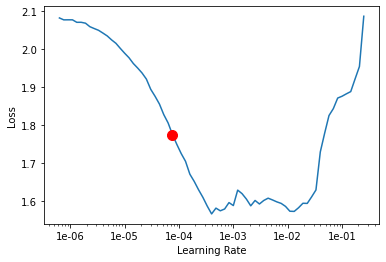

In [0]:
learn4.lr_find()
learn4.recorder.plot(suggestion = True)

In [0]:
learn3.fit_one_cycle(10, 7e-05)

epoch,train_loss,valid_loss,accuracy,time
0,0.603358,0.909764,0.708333,00:11
1,0.574384,0.679646,0.791667,00:11
2,0.535912,0.510887,0.858333,00:12
3,0.512199,0.533077,0.825000,00:12
4,0.484315,0.449358,0.891667,00:11
5,0.457079,0.417405,0.866667,00:12
6,0.412831,0.437970,0.875000,00:12
7,0.376165,0.239004,0.950000,00:11
8,0.349119,0.216592,0.950000,00:12
9,0.317619,0.211795,0.950000,00:11
